### LSTM Sentiment Classifier

## import libraries

In [ ]:
import numpy as np
import random
import sys
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns


from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.legacy import data, vocab
from torchtext.data.utils import get_tokenizer

In [ ]:
def set_seed(seed = 1234):
    """
    Function to set the seed of the entire notebook for reproducibility of results
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

## check for GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## 1. DATA

## process data with Torchtext and TabularDataset

In [ ]:
# Define a tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Initialize torchtext Field objects
# Include_lengths tells the RNN how long the actual sequences are
TEXT = data.Field(tokenize=tokenizer, lower=True, include_lengths= True)
LABEL = data.LabelField(dtype=torch.float)

# map data to fields
fields = [('review', TEXT), ('sentiment', LABEL)]

In [ ]:
# Use TabularDataset to create training, validation, and testing torch datasets (from csv)
# by applying field objects, which were initialized beforehand

train_data, valid_data, test_data = data.TabularDataset.splits( 
    path="/content/", 
    train="data_train.csv", 
    validation="data_dev.csv",
    test = "data_test.csv",
    format="csv", 
    skip_header=True, 
    fields=fields)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')
print(f'Number of test examples: {len(test_data)}')

Number of training examples: 40999
Number of valid examples: 4500
Number of test examples: 4501


In [ ]:
print(vars(train_data.examples[0]))

{'review': ['this', 'is', 'in', 'short', 'the', 'tv', 'comedy', 'series', 'with', 'the', 'best', 'cast', 'ever', 'and', 'the', 'most', 'likable', 'also', 'each', 'one', 'of', 'them', 'is', 'first', 'hand', 'comedy', 'actor', 'know', 'only', 'one', 'tv', 'series', 'which', 'was', 'better', 'e', 'moonlighting', 'that', 'one', 'had', 'willis', 'as', 'lead', 'yet', 'it', 'had', 'willis', 'only', 'while', 'the', 'king', 'of', 'queens', 'has', 'pocketful', 'of', 'actors', 'that', 'are', 'as', 'fine', 'as', 'one', 'can', 'enjoy', 'kevin', 'james', 'leah', 'remini', 'jerry', 'stiller', 'patton', 'oswalt', 'nicole', 'sullivan', 'victor', 'williams', 'gary', 'valentine', 'and', 'even', 'all', 'the', 'rest', 'of', 'them', 'spontaneously', 'and', 'continually', 'and', 'promptly', 'liked', 'it', 'advancing', 'age', 'did', 'not', 'spoil', 'the', 'fun', 'anyway', 'in', 'few', 'words', 'the', 'series', 'is', 'intelligent', 'and', 'original', 'miraculously', 'spared', 'of', 'the', 'current', 'tv', 'stu

## build Vocabulary (with or without Glove pretrained embeddings)

In [ ]:
# Build vocabulary objects (convert words into integers) for the training set

MAX_VOCAB_SIZE = 20000

# Without Glove (uncomment to run)
#TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)

# With Glove pretrained (uncomment to run)
#TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE,vectors = "glove.6B.100d",unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 17857.00it/s]


In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 20002
Unique tokens in LABEL vocabulary: 2


In [ ]:
# Most frequent tokens
TEXT.vocab.freqs.most_common(10)

[('the', 547738),
 ('and', 265893),
 ('of', 237095),
 ('to', 219592),
 ('is', 213467),
 ('it', 156349),
 ('in', 153092),
 ('this', 123727),
 ('that', 118573),
 ('#', 109039)]

## initialize iterators that batch examples of similar lengths together with BucketIterator

In [ ]:
BATCH_SIZE = 128

# sort_within_batch sorts all the tensors within a batch by their lengths
# BucketIterator groups input data (reviews) of similar lengths together for minimized padding in each batch

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.review),
    sort_within_batch = True)

## 2. MODEL: bidirectional stacked RNN with LSTM cell

In [ ]:
class Sentiment_Classifier_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        """
        Initialize the RNN model that will be used 
        to perform sentiment analysis, by setting up the layers

        vocab_size - input size (unique words in the vocabulary)
        embedding_dim - size of the dense word vectors (number of features for each time step)
        hidden_dim - size of the hidden states
        output_dim - number of classes
        n_layers - number of multi-layer RNN
        bidirectional - boolean - use both directions of LSTM
        dropout - dropout probability
        pad_idx -  string representing the pad token
        """
        
        super().__init__()

        # 1. Feed the reviews in the embedding layer
        # padding_idx set to not learn the emedding for the <pad> token - irrelevant to determining sentiment
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # 2. LSTM layer
        # returns the output and a tuple of the final hidden state and final cell state
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout)
        
        # 3. Fully-connected layer
        # Final hidden state has both a forward and a backward component concatenated together
        # The size of the input to the nn.Linear layer is twice that of the hidden dimension size
        self.predictor = nn.Linear(hidden_dim*2, output_dim)

        # Initialize dropout layer for regularization
        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text, text_lengths):
        """
        Function to call when data is fed into the model

        text - [review length, batch size]
        text_lengths - length of batch
        """

        # embedded = [sentence len, batch size, emb dim]
        embedded = self.dropout(self.embedding(text))    

        # Pack the embeddings - cause RNN to only process non-padded elements
        # Speeds up computation
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu())

        # output of lstm
        packed_output, (hidden, cell) = self.encoder(packed_embedded)

        # unpack sequence - transform packed sequence to a tensor
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sentence len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # Get the final layer forward and backward hidden states  
        # concat the final forward and backward hidden layers and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        # hidden = [batch size, hid dim * num directions]

        # return output after it had passed through a fully-connected layer
        return self.predictor(hidden)

## 3. CREATE MODEL 

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
# 2 layers of biLSTM
N_LAYERS = 2
BIDIRECTIONAL = True
# Dropout probability
DROPOUT = 0.2
# Get pad token index from vocab
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Create an instance of LSTM class
model = Sentiment_Classifier_LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

## run this cell only if pretrained embeddings are used (else skip it and go on to the next one)

In [ ]:
# Copy the pre-trained word embeddings into the embedding layer
pretrained_embeddings = TEXT.vocab.vectors

# [vocab size, embedding dim]
print(pretrained_embeddings.shape)

# copy the pre-trained word embeddings into the embedding layer
model.embedding.weight.data.copy_(TEXT.vocab.vectors)
print(model.embedding.weight)


# Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# Setting row in the embedding weights matrix to zero using the token index
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# Freeze weights
model.embedding.weight.requires_grad=False

print(model.embedding.weight)


torch.Size([20002, 100])
Parameter containing:
tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.2215, -0.0018,  0.7275,  ..., -0.6555, -0.4417,  0.4873],
        [ 0.1070,  0.1660,  0.8914,  ..., -0.6368,  0.2450,  1.0492],
        [-0.3429,  1.0147,  0.3113,  ..., -0.0477,  0.2576,  0.1918]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.2215, -0.0018,  0.7275,  ..., -0.6555, -0.4417,  0.4873],
        [ 0.1070,  0.1660,  0.8914,  ..., -0.6368,  0.2450,  1.0492],
        [-0.3429,  1.0147,  0.3113,  ..., -0.0477,  0.2576,  0.1918]])


In [ ]:
# Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# Setting row in the embedding weights matrix to zero using the token index
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7289, -0.7336,  1.5624,  ..., -0.5592, -0.4480, -0.6476],
        ...,
        [-0.4019, -1.6036,  0.7195,  ...,  0.8753,  1.2358,  0.2100],
        [-0.2028,  0.4162, -0.0036,  ...,  0.7825,  0.1047,  1.1312],
        [-0.0591,  0.4980, -0.3215,  ..., -0.6867,  0.5813,  1.2588]])


In [ ]:
# Adam optimizer used to update the weights
optimizer = optim.Adam(model.parameters(), lr=2e-2)

# Loss function: binary cross entropy with logits
# It restricts the predictions to a number between 0 and 1 using the logit function
# then use the bound scarlar to calculate the loss using binary cross entropy
criterion = nn.BCEWithLogitsLoss()

# Use GPU
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# Helper functions

def batch_accuracy(predictions, label):
    """
    Returns accuracy per batch.

    predictions - float
    label - 0 or 1
    """

    # Round predictions to the closest integer using the sigmoid function
    preds = torch.round(torch.sigmoid(predictions))
    # If prediction is equal to label
    correct = (preds == label).float()
    # Average correct predictions
    accuracy = correct.sum() / len(correct)

    return accuracy

def timer(start_time, end_time):
    """
    Returns the minutes and seconds.
    """

    time = end_time - start_time
    mins = int(time / 60)
    secs = int(time - (mins * 60))

    return mins, secs

In [ ]:
def train(model, iterator, optimizer, criterion):
    """
    Function to evaluate training loss and accuracy.

    iterator - train iterator
    """
    
    # Cumulated Training loss
    training_loss = 0.0
    # Cumulated Training accuracy
    training_acc = 0.0
    
    # Set model to training mode
    model.train()
    
    # For each batch in the training iterator
    for batch in iterator:
        
        # 1. Zero the gradients
        optimizer.zero_grad()
        
        # batch.text is a tuple (tensor, len of seq)
        text, text_lengths = batch.review
        
        # 2. Compute the predictions
        predictions = model(text, text_lengths).squeeze(1)
        
        # 3. Compute loss
        loss = criterion(predictions, batch.sentiment)
        
        # Compute accuracy
        accuracy = batch_accuracy(predictions, batch.sentiment)
        
        # 4. Use loss to compute gradients
        loss.backward()
        
        # 5. Use optimizer to take gradient step
        optimizer.step()
        
        training_loss += loss.item()
        training_acc += accuracy.item()
    
    # Return the loss and accuracy, averaged across each epoch
    # len of iterator = num of batches in the iterator
    return training_loss / len(iterator), training_acc / len(iterator)

def evaluate(model, iterator, criterion):
    """
    Function to evaluate the loss and accuracy of validation and test sets.

    iterator - validation or test iterator
    """
    
    # Cumulated Training loss
    eval_loss = 0.0
    # Cumulated Training accuracy
    eval_acc = 0
    
    # Set model to evaluation mode
    model.eval()
    
    # Don't calculate the gradients
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.review
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.sentiment)
            
            accuracy = batch_accuracy(predictions, batch.sentiment)

            eval_loss += loss.item()
            eval_acc += accuracy.item()
        
    return eval_loss / len(iterator), eval_acc / len(iterator)

## 4. TRAINING

In [ ]:
# Number of epochs
NUM_EPOCHS = 5

# Lowest validation lost
best_valid_loss = float('inf')

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    
    # Evaluate training loss and accuracy
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    # Evaluate validation loss and accuracy
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    # At each epoch, if the validation loss is the best
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # Save the parameters of the model
        torch.save(model.state_dict(), 'model.pt')

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

Epoch 1:
	 Total Time: 1m 13s
	 Train Loss 0.57 | Train Accuracy: 67.53%
	 Validation Loss 0.44 | Validation Accuracy: 79.29%
Epoch 2:
	 Total Time: 1m 12s
	 Train Loss 0.38 | Train Accuracy: 83.31%
	 Validation Loss 0.34 | Validation Accuracy: 85.72%
Epoch 3:
	 Total Time: 1m 12s
	 Train Loss 0.34 | Train Accuracy: 85.69%
	 Validation Loss 0.3 | Validation Accuracy: 88.06%
Epoch 4:
	 Total Time: 1m 12s
	 Train Loss 0.31 | Train Accuracy: 86.7%
	 Validation Loss 0.29 | Validation Accuracy: 88.28%
Epoch 5:
	 Total Time: 1m 12s
	 Train Loss 0.31 | Train Accuracy: 87.06%
	 Validation Loss 0.3 | Validation Accuracy: 87.6%


## 5. EVALUATING

In [ ]:
# Load the model with the best validation loss
model.load_state_dict(torch.load('model.pt'))

# Evaluate test loss and accuracy
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print("Test Loss: {} | Test Acc: {}%".format(round(test_loss, 2), round(test_acc*100, 2)))

Test Loss: 0.31 | Test Acc: 87.01%


In [ ]:
def predict(model, text):
    """
    Function to predict the sentiment given a tweet
    """

    # Set model to evaluation mode
    model.eval()
    
    # Index tokens by converting to the integer representation from the vocabulary
    indexed_tokens = [TEXT.vocab.stoi[t] for t in text]
    # Get the length of the text
    length = [len(indexed_tokens)]
    # Convert the indices to a tensor
    tensor = torch.LongTensor(indexed_tokens).to(device)
    # Add a batch dimension by unsqueezeing
    tensor = tensor.unsqueeze(1)
    # Convert the length into a tensor
    length_tensor = torch.LongTensor(length)
    # Get prediction
    prediction = torch.sigmoid(model(tensor, length_tensor))
    # Binarize prediction
    y_pred_tag = torch.round(prediction)

    return y_pred_tag

In [ ]:
# Use testing dataset for inference

predicted_labels = []
true_labels = []

for i in range(4501):
  with torch.no_grad():
    text = test_data[i].review
    label = test_data[i].sentiment
    preds = predict(model, text)
    predicted_labels.append(preds.cpu().numpy())
    true_labels +=[int(label)]

predicted_labels = [a.squeeze().tolist() for a in predicted_labels]
predicted_labels = [int(a)for a in predicted_labels]

#print(predicted_labels)
#print(true_labels)

## Confusion Matrix

best

                  precision    recall  f1-score   support

class 0_negative       0.87      0.88      0.87      2250
class 1_positive       0.88      0.87      0.87      2251

        accuracy                           0.87      4501
       macro avg       0.87      0.87      0.87      4501
    weighted avg       0.87      0.87      0.87      4501



Text(91.68, 0.5, 'predicted label')

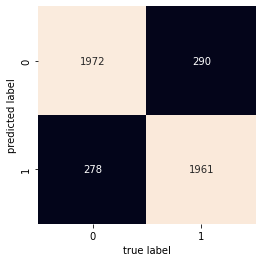

In [ ]:
# metrics report
target_names = ['class 0_negative', 'class 1_positive']
scores = metrics.classification_report(true_labels, predicted_labels, target_names=target_names)
print('best\n')
print(scores)
mat = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')